# Final Project
Abigail Allen  
Josh Urry  
Trevor Jex

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mutual_info_score, confusion_matrix, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data
df = pd.read_csv("Motor_Vehicle_Crashes_-_Case_Information__Three_Year_Window.csv")

In [3]:
df.head()

,Year,Crash Descriptor,Time,Date,Day of Week,Police Report,Lighting Conditions,Municipality,Collision Type Descriptor,County Name,Road Descriptor,Weather Conditions,Traffic Control Device,Road Surface Conditions,DOT Reference Marker Location,Pedestrian Bicyclist Action,Event Descriptor,Number of Vehicles Involved
0,2017,Property Damage & Injury Accident,6:49,01/03/2017,Tuesday,Y,Dawn,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Cloudy,Traffic Signal,Wet,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2
1,2017,Injury Accident,17:17,01/02/2017,Monday,Y,Dark-Road Lighted,HEMPSTEAD,OTHER,NASSAU,Straight and Level,Rain,Stop Sign,Wet,NaN,"Crossing, With Signal","Pedestrian, Collision With",1
2,2017,Property Damage Accident,22:50,01/02/2017,Monday,Y,Dark-Road Lighted,HEMPSTEAD,LEFT TURN (3),NASSAU,Straight and Level,Rain,Traffic Signal,Wet,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2
3,2017,Property Damage Accident,10:00,01/03/2017,Tuesday,Y,Daylight,HEMPSTEAD,OVERTAKING,NASSAU,Straight and Level,Rain,Traffic Signal,Wet,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2
4,2017,Property Damage Accident,7:05,01/03/2017,Tuesday,Y,Daylight,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Cloudy,NaN,Wet,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2


In [4]:
# Check number of samples
len(df)

1890537

## Preprocessing

In [5]:
# Check NA values
df.isna().sum()

Year                                   0
Crash Descriptor                       0
Time                                   0
Date                                   0
Day of Week                            0
Police Report                          0
Lighting Conditions                    0
Municipality                       14620
Collision Type Descriptor              0
County Name                            0
Road Descriptor                        0
Weather Conditions                     0
Traffic Control Device           1085488
Road Surface Conditions                0
DOT Reference Marker Location    1257386
Pedestrian Bicyclist Action            0
Event Descriptor                       0
Number of Vehicles Involved            0
dtype: int64

Let's drop the "DOT Reference Marker Location" variable, since the majority of accidents have this missing. Maybe we could just remove the rows where the Municipality is blank. Or just drop it as well and just use the County.

In [6]:
df.drop("DOT Reference Marker Location", axis = 1, inplace = True)

Let's figure out how to handle the date variables.

In [7]:
df.Year.unique()

array([2017, 2019, 2021, 2018, 2020])

We could represent these as 0, 1, 2, 3, and 4 as a variable that represents "years from 2017", so it is numeric.

In [8]:
# It may not make a big difference if we don't do this. It makes the charts confusing so let's keep it for now.
# df.Year.replace({2017: 0, 2018: 1, 2019: 2, 2020: 3, 2021: 4}, inplace = True)

Let's convert time and date to date time objects and extract the minutes, hours, month, and day

In [9]:
df.Time = pd.to_datetime(df.Time)
df.Date = pd.to_datetime(df.Date)

/var/folders/lh/ptq87vy13l37_4kfpj8px4mr0000gn/T/ipykernel_29717/1106775589.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.Time = pd.to_datetime(df.Time)


In [10]:
df["month"] = df.Date.dt.month
df["day"] = df.Date.dt.day
df["hour"] = df.Time.dt.hour
df["minute"] = df.Time.dt.minute # My guess is that we'll end up dropping this

In [11]:
# Drop Date and Time variables 
# df.drop(["Date", "Time"], axis = 1, inplace = True)
df.drop(["Date"], axis = 1, inplace = True)

In [12]:
# Now let's convert day of the week to numeric
df["Day of Week"].replace({"Sunday": 0, "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4,
                          "Friday": 5, "Saturday": 6}, inplace = True)

In [13]:
df.head()

,Year,Crash Descriptor,Time,Day of Week,Police Report,Lighting Conditions,Municipality,Collision Type Descriptor,County Name,Road Descriptor,Weather Conditions,Traffic Control Device,Road Surface Conditions,Pedestrian Bicyclist Action,Event Descriptor,Number of Vehicles Involved,month,day,hour,minute
0,2017,Property Damage & Injury Accident,2023-04-26 06:49:00,2,Y,Dawn,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Cloudy,Traffic Signal,Wet,Not Applicable,"Other Motor Vehicle, Collision With",2,1,3,6,49
1,2017,Injury Accident,2023-04-26 17:17:00,1,Y,Dark-Road Lighted,HEMPSTEAD,OTHER,NASSAU,Straight and Level,Rain,Stop Sign,Wet,"Crossing, With Signal","Pedestrian, Collision With",1,1,2,17,17
2,2017,Property Damage Accident,2023-04-26 22:50:00,1,Y,Dark-Road Lighted,HEMPSTEAD,LEFT TURN (3),NASSAU,Straight and Level,Rain,Traffic Signal,Wet,Not Applicable,"Other Motor Vehicle, Collision With",2,1,2,22,50
3,2017,Property Damage Accident,2023-04-26 10:00:00,2,Y,Daylight,HEMPSTEAD,OVERTAKING,NASSAU,Straight and Level,Rain,Traffic Signal,Wet,Not Applicable,"Other Motor Vehicle, Collision With",2,1,3,10,0
4,2017,Property Damage Accident,2023-04-26 07:05:00,2,Y,Daylight,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Cloudy,NaN,Wet,Not Applicable,"Other Motor Vehicle, Collision With",2,1,3,7,5


Let's figure out the target variable

In [14]:
df["Event Descriptor"].unique()

array(['Other Motor Vehicle, Collision With',
       'Pedestrian, Collision With',
       'Earth Embankment/Rock Cut/Ditch, Collision With Fixed Object',
       'Bicyclist, Collision With',
       'Fire Hydrant, Collision With Fixed Object',
       'Other Fixed Object*, Collision With Fixed Object',
       'Barrier, Collision With Fixed Object',
       'Curbing, Collision With Fixed Object',
       'Building/Wall, Collision With Fixed Object',
       'Light Support/Utility Pole, Collision With Fixed Object',
       'Median - Not At End, Collision With Fixed Object',
       'Tree, Collision With Fixed Object', 'Deer',
       'Overturned, Non-Collision',
       'Guide Rail - Not At End, Collision With Fixed Object',
       'Guide Rail - End, Collision With Fixed Object',
       'Animal, Collision With',
       'Bridge Structure, Collision With Fixed Object',
       'Other Object (Not Fixed)*, Collision With',
       'Snow Embankment, Collision With Fixed Object',
       'Sign Post, Colli

In [15]:
df["Crash Descriptor"].unique()

array(['Property Damage & Injury Accident', 'Injury Accident',
       'Property Damage Accident', 'Fatal Accident'], dtype=object)

We wil use the crash descriptor variable as the outcome.

## Data Visualization

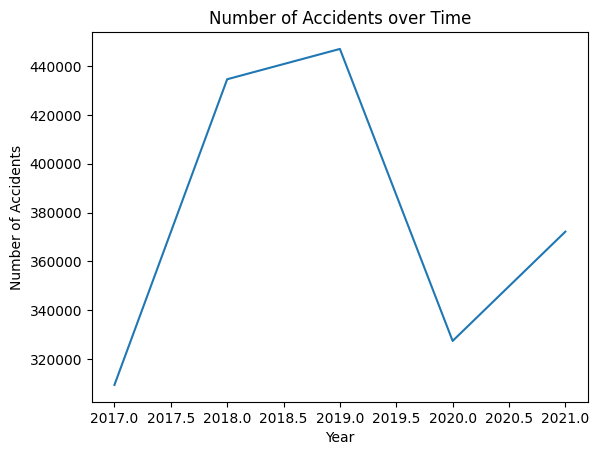

In [16]:
# Lineplot of accidents over time
df.groupby('Year')['Time'].count().plot()
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents over Time')
plt.show()

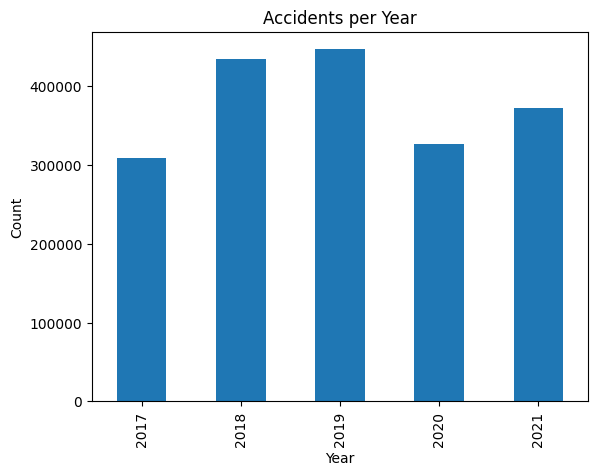

In [17]:
# Barplot of accidents per year
counts = df['Year'].value_counts().sort_index()
counts.plot.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Accidents per Year')
plt.show()

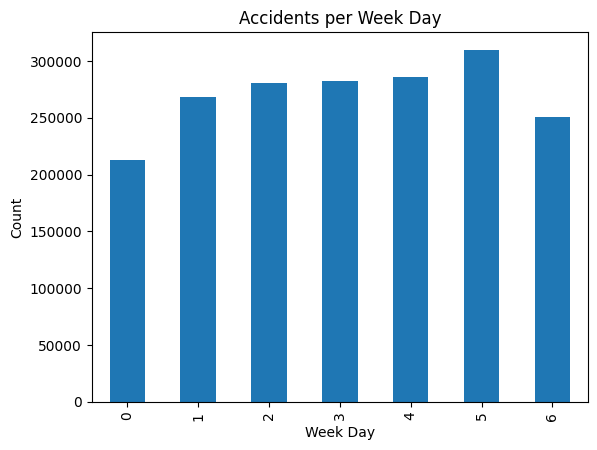

In [18]:
# Barplot of accidents per week
counts = df['Day of Week'].value_counts().sort_index()
counts.plot.bar()
plt.xlabel('Week Day')
plt.ylabel('Count')
plt.title('Accidents per Week Day')
plt.show()

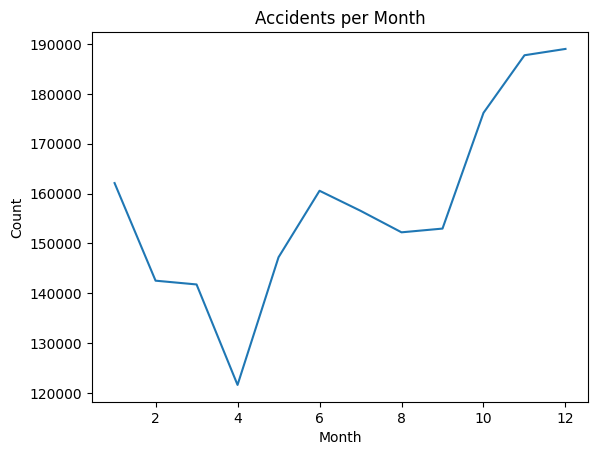

In [19]:
# Barplot of accidents per week
counts = df['month'].value_counts().sort_index()
counts.plot.line()
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month')
plt.show()

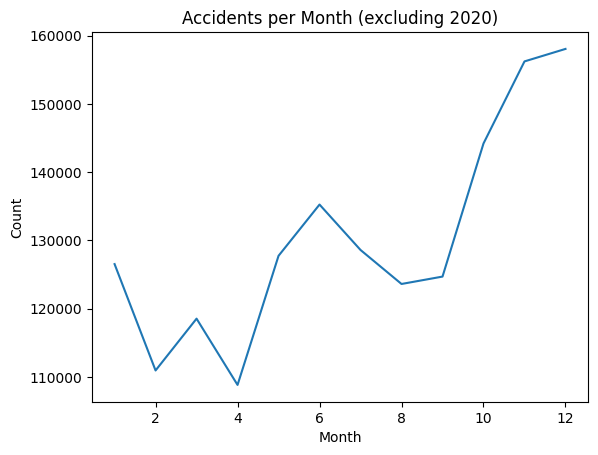

In [20]:
# Barplot of accidents per week, excluding 2020
counts = df[df['Year'] != 2020]['month'].value_counts().sort_index()
counts.plot.line()
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (excluding 2020)')
plt.show()

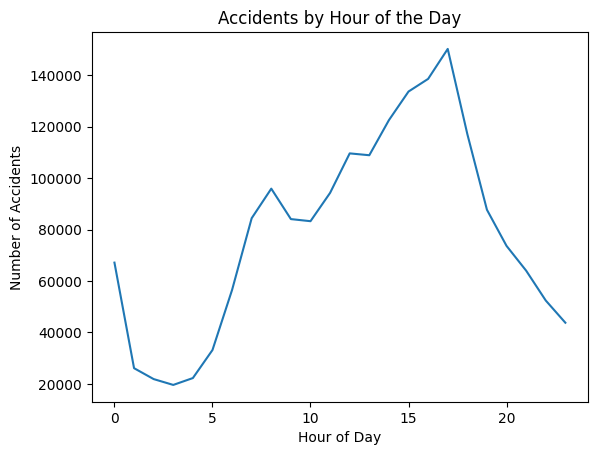

In [21]:
df_grouped = df.groupby('hour').count()
plt.plot(df_grouped.index, df_grouped['Number of Vehicles Involved'])

plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Hour of the Day')
plt.show()

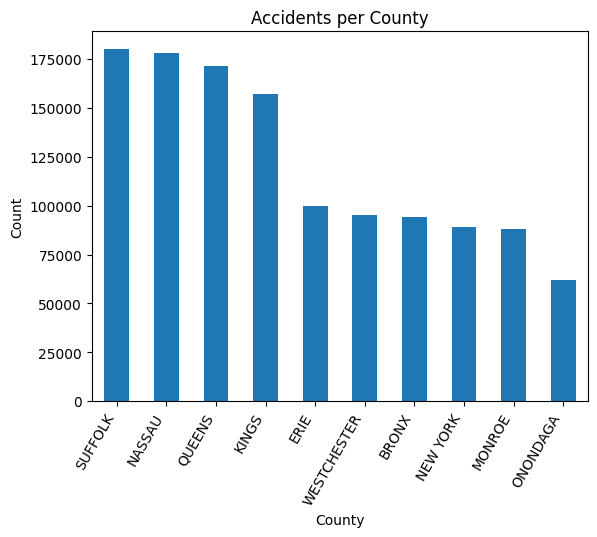

In [22]:
# Barplot of top 10 accidents per county
counts = df['County Name'].value_counts().head(10)
counts.plot.bar()
plt.xlabel('County')
plt.ylabel('Count')
plt.title('Accidents per County')
plt.xticks(rotation=60, ha='right')
plt.show()

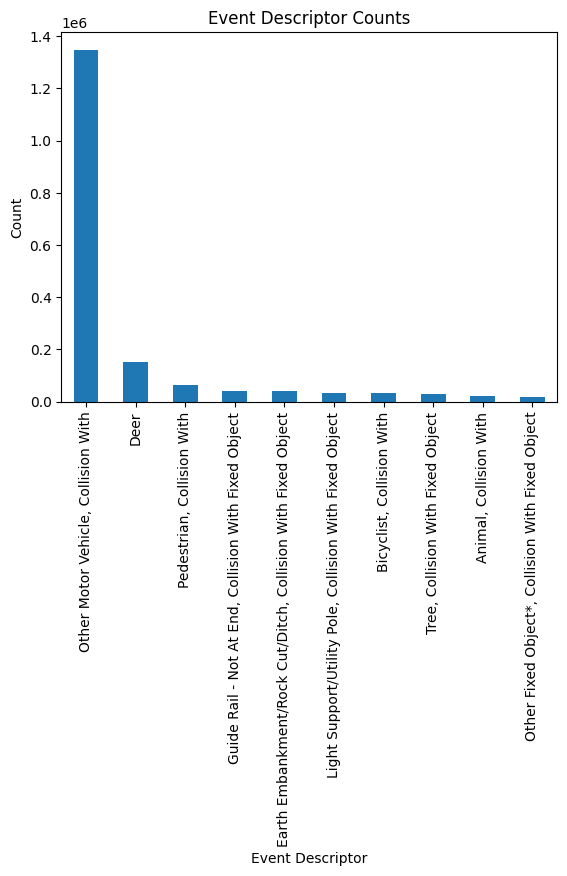

In [23]:
# Barplot of top 10 event decriptors
counts = df['Event Descriptor'].value_counts().head(10)
counts.plot.bar()
plt.xlabel('Event Descriptor')
plt.ylabel('Count')
plt.title('Event Descriptor Counts')
plt.show()

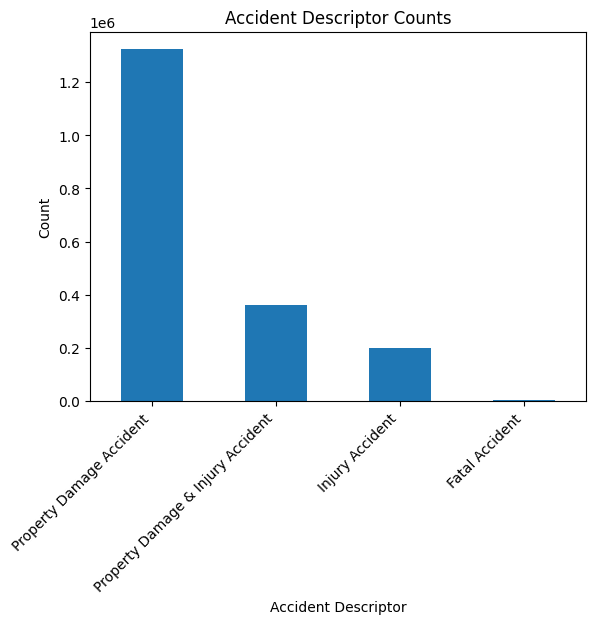

In [24]:
# Barplot of about of accident descriptors
counts = df['Crash Descriptor'].value_counts()
counts.plot.bar()
plt.xlabel('Accident Descriptor')
plt.ylabel('Count')
plt.title('Accident Descriptor Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

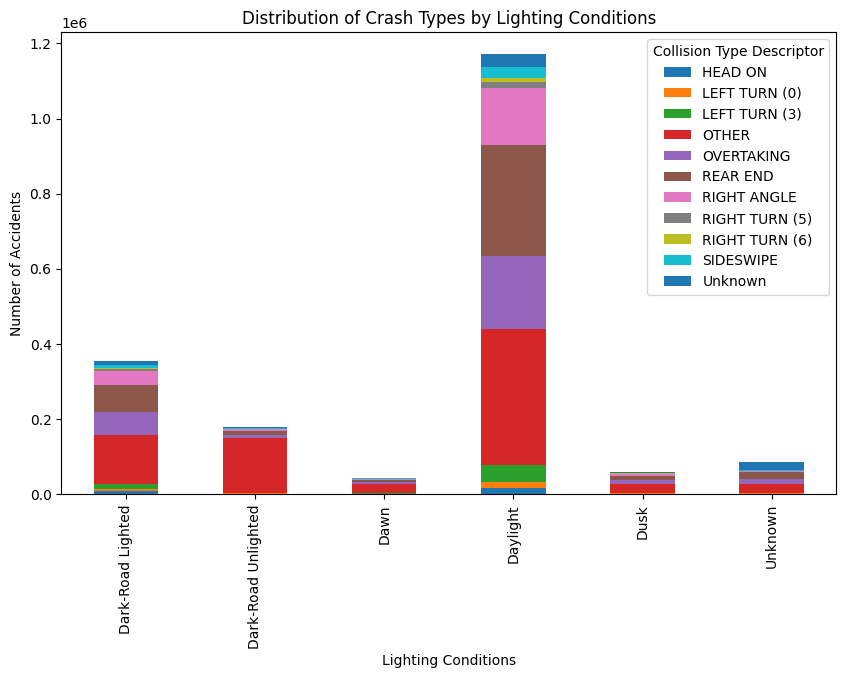

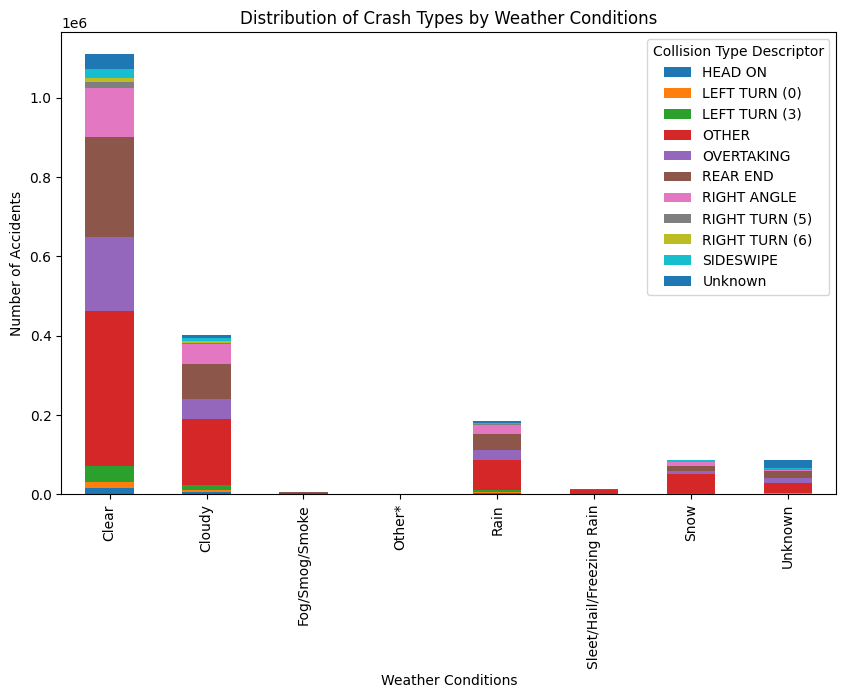

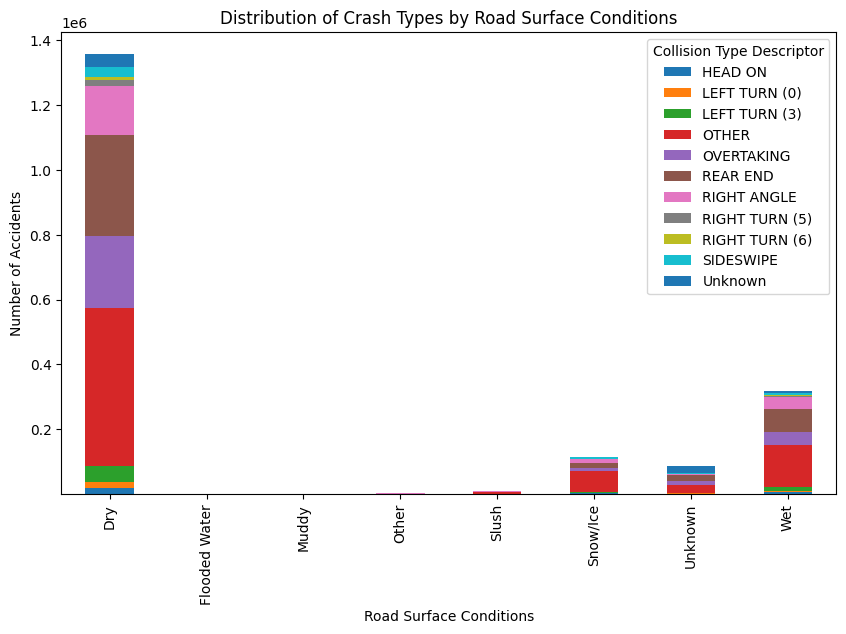

In [25]:
# Stacked barchart of lighting, weather, road surface, and traffice control device per accident description
conditions = ['Lighting Conditions', 'Weather Conditions', 'Road Surface Conditions']

# Create a list of pivot tables and charts for each condition
for condition in conditions:
    pivot_table = df.pivot_table(index=condition, columns='Collision Type Descriptor', values='Year', aggfunc='count')
    ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

    ax.set_title(f'Distribution of Crash Types by {condition}')
    ax.set_xlabel(condition)
    ax.set_ylabel('Number of Accidents')
    plt.show()

In [26]:
# Drop Time
df.drop("Time", axis = 1 , inplace = True)

## Feature Extraction

One hot encoding all of the categorical variables leaves us with a lot of features. Let's see if we can do some feature extraction to whittle that down. Let's start with the event descriptor variable.

In [27]:
df["Event Descriptor"].unique()

array(['Other Motor Vehicle, Collision With',
       'Pedestrian, Collision With',
       'Earth Embankment/Rock Cut/Ditch, Collision With Fixed Object',
       'Bicyclist, Collision With',
       'Fire Hydrant, Collision With Fixed Object',
       'Other Fixed Object*, Collision With Fixed Object',
       'Barrier, Collision With Fixed Object',
       'Curbing, Collision With Fixed Object',
       'Building/Wall, Collision With Fixed Object',
       'Light Support/Utility Pole, Collision With Fixed Object',
       'Median - Not At End, Collision With Fixed Object',
       'Tree, Collision With Fixed Object', 'Deer',
       'Overturned, Non-Collision',
       'Guide Rail - Not At End, Collision With Fixed Object',
       'Guide Rail - End, Collision With Fixed Object',
       'Animal, Collision With',
       'Bridge Structure, Collision With Fixed Object',
       'Other Object (Not Fixed)*, Collision With',
       'Snow Embankment, Collision With Fixed Object',
       'Sign Post, Colli

As shown above, there are alot of categories for this one. The visualizations also show that there are relatively few occurances besides collision with another car. Let's just recode them as "Collision with Fixed Object", "Collision with Other Vehicle", "Collision with Pedestrian/Animal", and "Non-Collision"

In [28]:
# Define conditions to recode
conditions = [
    # Conditions for "Collision with Fixed Object"
    ((df["Event Descriptor"] == "Earth Embankment/Rock Cut/Ditch, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Fire Hydrant, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Other Fixed Object*, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Barrier, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Curbing, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Building/Wall, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Light Support/Utility Pole, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Median - Not At End, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Tree, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Guide Rail - Not At End, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Guide Rail - End, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Bridge Structure, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Snow Embankment, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Sign Post, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Culver/Head Wall, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Fence, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Crash Cushion, Collision With Fixed Object") |
    (df["Event Descriptor"] == "Median - End, Collision With Fixed Object")),
    # Conditions for "Collision with Other Vehicle (I'm going to count trains in here too)"
    ((df["Event Descriptor"] == "Other Motor Vehicle, Collision With") |
    (df["Event Descriptor"] == "Railroad Train, Collision With")),
    # Conditions for "Collision with Pedestrian/Animal"
    ((df["Event Descriptor"] == "Pedestrian, Collision With") | 
     (df["Event Descriptor"] == "Bicyclist, Collision With") |
     (df["Event Descriptor"] == "Deer") | (df["Event Descriptor"] == "Animal, Collision With") | 
     (df["Event Descriptor"] == "Other Pedestrian")| (df["Event Descriptor"] == "In-Line Skater, Collision With")|
     (df["Event Descriptor"] == "Other Object (Not Fixed)*, Collision With")),
    # Conditions for "Non-Collision"
    ((df["Event Descriptor"] == "Overturned, Non-Collision") | (df["Event Descriptor"] == "Other*, Non-Collision") |
     (df["Event Descriptor"] == "Ran Off Roadway Only, Non-Collision") |
     (df["Event Descriptor"] == "Submersion, Non-Collision") | 
     (df["Event Descriptor"] == "Fire/Explosion, Non-Collision"))
]

# Corresponding values with the four conditions
value = [
    "Collision with Fixed Object",
    "Collision with Other Vehicle",
    "Collision with Pedestrian/Animal",
    "Non-Collision"
    ]

# Recode
df["Event Descriptor"] = np.select(conditions, value)

In [29]:
df["Event Descriptor"].unique()

array(['Collision with Other Vehicle', 'Collision with Pedestrian/Animal',
       'Collision with Fixed Object', 'Non-Collision'], dtype=object)

We may lose some information here, but it is much more manageable. Let's look at collision type descriptor next.

In [30]:
df["Collision Type Descriptor"].unique()

array(['REAR END', 'OTHER', 'LEFT TURN (3)', 'OVERTAKING', 'RIGHT ANGLE',
       'SIDESWIPE', 'RIGHT TURN (6)', 'RIGHT TURN (5)', 'Unknown',
       'LEFT TURN (0)', 'HEAD ON'], dtype=object)

In [31]:
# Look at frequencies of co-occurences
ctd_frequencies = pd.crosstab(df["Collision Type Descriptor"], df["Crash Descriptor"], normalize = "index")
ctd_frequencies

Crash Descriptor,Fatal Accident,Injury Accident,Property Damage & Injury Accident,Property Damage Accident
Collision Type Descriptor,,,,
HEAD ON,0.014359,0.068829,0.400134,0.516678
LEFT TURN (0),0.000881,0.076190,0.229130,0.693799
LEFT TURN (3),0.001650,0.059599,0.293154,0.645596
OTHER,0.004700,0.152519,0.189764,0.653017
OVERTAKING,0.000227,0.043054,0.088904,0.867816
REAR END,0.000461,0.110634,0.206575,0.682330
RIGHT ANGLE,0.001874,0.055097,0.292041,0.650988
RIGHT TURN (5),0.000296,0.068795,0.142537,0.788372
RIGHT TURN (6),0.000502,0.047290,0.147208,0.804999


I'm not quite sure what the difference is between the different left/right turn variables. There seem to be some minor differences above, but nothing substantial. Let's combine those.

In [32]:
df["Collision Type Descriptor"].replace({"LEFT TURN (3)": "LEFT TURN", "LEFT TURN (0)": "LEFT TURN",
                                        "RIGHT TURN (6)": "RIGHT TURN", "RIGHT TURN (5)": "RIGHT TURN"}, inplace = True)

In [33]:
df["Collision Type Descriptor"].unique()

array(['REAR END', 'OTHER', 'LEFT TURN', 'OVERTAKING', 'RIGHT ANGLE',
       'SIDESWIPE', 'RIGHT TURN', 'Unknown', 'HEAD ON'], dtype=object)

Lighting and Road Descriptor look fine. I'm thinking we may only need one of the road surface or weather condition variables. Let's check their mutual information.

In [34]:
df["Road Surface Conditions"].unique()

array(['Wet', 'Dry', 'Snow/Ice', 'Unknown', 'Slush', 'Flooded Water',
       'Other', 'Muddy'], dtype=object)

In [35]:
df["Weather Conditions"].unique()

array(['Cloudy', 'Rain', 'Clear', 'Snow', 'Unknown',
       'Sleet/Hail/Freezing Rain', 'Other*', 'Fog/Smog/Smoke'],
      dtype=object)

In [36]:
# Look at frequencies of co-occurences
cond_frequencies = pd.crosstab(df["Road Surface Conditions"], df["Weather Conditions"], normalize = "index")
cond_frequencies

Weather Conditions,Clear,Cloudy,Fog/Smog/Smoke,Other*,Rain,Sleet/Hail/Freezing Rain,Snow,Unknown
Road Surface Conditions,,,,,,,,
Dry,0.775719,0.218575,0.002035,0.000502,0.000708,0.000032,0.000108,0.002320
Flooded Water,0.145581,0.069324,0.013865,0.000000,0.714038,0.015598,0.015598,0.025997
Muddy,0.339549,0.331698,0.005888,0.002944,0.250245,0.005888,0.040236,0.023553
Other,0.707570,0.188034,0.006716,0.056777,0.016484,0.001221,0.013431,0.009768
Slush,0.223147,0.217402,0.000938,0.000235,0.051126,0.143996,0.358114,0.005042
Snow/Ice,0.141254,0.139680,0.000796,0.000502,0.014949,0.085230,0.610643,0.006947
Unknown,0.030448,0.006479,0.000490,0.000280,0.001985,0.000175,0.000712,0.959430
Wet,0.104637,0.269867,0.007211,0.000329,0.567568,0.008018,0.040361,0.002010


In [37]:
# Look at mutual info
mutual_info_score(df["Road Surface Conditions"], df["Weather Conditions"])

0.521534497522493

It looks like these are really related. Let's just stick with road contitions, since I feel that is more applicable here.

In [38]:
df.drop("Weather Conditions", axis = 1, inplace = True)

Now, let's look at Traffic Control Devices

In [39]:
df["Traffic Control Device"].value_counts()

Traffic Control Device
Traffic Signal                            397242
Stop Sign                                 159747
No Passing Zone                           109379
Unknown                                    90418
Other                                      17236
Yield Sign                                 14636
Construction Work Area                      5628
Flashing Light                              3742
Police/Fire Emergency                       1445
RR Crossing Gates                           1262
Stopped School Bus-Red Lights Flashing       836
Officer/Guard                                814
Maintenance Work Area                        657
School Zone                                  644
Not Applicable                               526
RR Crossing Sign                             457
Utility Work Area                            268
RR Crossing Flashing Light                   112
Name: count, dtype: int64

I'm not convinced this will be very informative. Check crosstabs.

In [40]:
# Look at frequencies of co-occurences
dev_frequencies = pd.crosstab(df["Traffic Control Device"], df["Crash Descriptor"], normalize = "index")
dev_frequencies

Crash Descriptor,Fatal Accident,Injury Accident,Property Damage & Injury Accident,Property Damage Accident
Traffic Control Device,,,,
Construction Work Area,0.001244,0.073028,0.200426,0.725302
Flashing Light,0.003741,0.091929,0.293426,0.610903
Maintenance Work Area,0.003044,0.062405,0.210046,0.724505
No Passing Zone,0.006080,0.017435,0.185831,0.790655
Not Applicable,0.000000,0.066540,0.146388,0.787072
Officer/Guard,0.001229,0.230958,0.135135,0.632678
Other,0.002495,0.088420,0.195231,0.713855
Police/Fire Emergency,0.001384,0.080277,0.271280,0.647059
RR Crossing Flashing Light,0.008929,0.232143,0.125000,0.633929


It looks like some features would potentially be useful in distinguishing some classes, like Officer/Guard for injury, or Police/Fire Emergency for property and injury, but overall there really doesn't seem to be that much variation between these. Let's drop for now. We can always add it in again.

In [41]:
df.drop("Traffic Control Device", axis = 1, inplace = True)

Now, Police Report

In [42]:
df["Police Report"].unique()

array(['Y', 'N'], dtype=object)

We can just recode this to a binary variable now, so we don't have a column we don't need from one hot encoding.

In [43]:
df["Police Report"].replace({"Y": 1, "N": 0}, inplace = True)

Finally, let's look at Pedestrian Bicyclist Action. Let's not worry about Municipality or County for now.

In [44]:
df["Pedestrian Bicyclist Action"].value_counts()

Pedestrian Bicyclist Action
Not Applicable                                          1789320
Unknown                                                   29966
Crossing, With Signal                                     21419
Crossing, No Signal or Crosswalk                          15987
Crossing, No Signal, Marked Crosswalk                      6705
Other Actions in Roadway                                   5980
Crossing, Against Signal                                   5785
Riding/Walking/Skating Along Highway With Traffic          4784
Not in Roadway (Indicate)                                  3298
Emerging from in Front of/Behind Parked Vehicle            2356
Riding/Walking/Skating Along Highway Against Traffic       2097
Working in Roadway                                         1214
Getting On/Off Vehicle Other than School Bus                928
Playing in Roadway                                          547
Pushing/Working On Car                                       95
Going to/Fro

These realatively do not happen that often. Let's drop for now.

In [45]:
df.head()

,Year,Crash Descriptor,Day of Week,Police Report,Lighting Conditions,Municipality,Collision Type Descriptor,County Name,Road Descriptor,Road Surface Conditions,Pedestrian Bicyclist Action,Event Descriptor,Number of Vehicles Involved,month,day,hour,minute
0,2017,Property Damage & Injury Accident,2,1,Dawn,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Wet,Not Applicable,Collision with Other Vehicle,2,1,3,6,49
1,2017,Injury Accident,1,1,Dark-Road Lighted,HEMPSTEAD,OTHER,NASSAU,Straight and Level,Wet,"Crossing, With Signal",Collision with Pedestrian/Animal,1,1,2,17,17
2,2017,Property Damage Accident,1,1,Dark-Road Lighted,HEMPSTEAD,LEFT TURN,NASSAU,Straight and Level,Wet,Not Applicable,Collision with Other Vehicle,2,1,2,22,50
3,2017,Property Damage Accident,2,1,Daylight,HEMPSTEAD,OVERTAKING,NASSAU,Straight and Level,Wet,Not Applicable,Collision with Other Vehicle,2,1,3,10,0
4,2017,Property Damage Accident,2,1,Daylight,HEMPSTEAD,REAR END,NASSAU,Straight and Level,Wet,Not Applicable,Collision with Other Vehicle,2,1,3,7,5


In [46]:
Xtransformer = ColumnTransformer(
[
    ('categorical', OneHotEncoder(), ['Collision Type Descriptor', 'Lighting Conditions', 'Road Descriptor', 
                                      'Road Surface Conditions', 'Event Descriptor']),
    ('drop', 'drop', ['Municipality', 'County Name', 'Pedestrian Bicyclist Action', 'Crash Descriptor'])   
],
    remainder='passthrough'
)

X = Xtransformer.fit_transform(df)
y = df[["Crash Descriptor"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Machine Learning

We start out with a dummy clasxifier (picks the most common class every time), and calculate the f1-score for that. We'll compare the confusion matrix and f1 score for some other classification methods.

In [47]:
model = DummyClassifier()

model.fit(X_train, y_train)

y_dummy_pred = model.predict(X_test)

In [48]:
confusion_matrix(y_test, y_dummy_pred)

array([[     0,      0,      0,    958],
       [     0,      0,      0,  39952],
       [     0,      0,      0,  72463],
       [     0,      0,      0, 264735]])

In [49]:
f1_score(y_test, y_dummy_pred, average='micro')

0.700157097972008

Now we will train a DecisionTreeClassifier on the data with default parameters.

In [50]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

y_decisiontree_pred = model.predict(X_test)

In [51]:
confusion_matrix(y_test, y_decisiontree_pred)

array([[    15,    168,    249,    526],
       [   222,  14028,   6846,  18856],
       [   304,   7116,  19862,  45181],
       [   708,  23085,  52219, 188723]])

In [52]:
f1_score(y_test, y_decisiontree_pred, average='micro')

0.5887947358955642

Giving the decision tree classifier a max depth of 10 yields better performance.

In [53]:
model = DecisionTreeClassifier(max_depth=10)

model.fit(X_train, y_train)

y_decisiontree_pred = model.predict(X_test)

In [54]:
confusion_matrix(y_test, y_decisiontree_pred)

array([[     2,    176,     63,    717],
       [     0,  13762,    883,  25307],
       [     2,   2072,   3141,  67248],
       [     4,   6739,   2644, 255348]])

In [55]:
f1_score(y_test, y_decisiontree_pred, average='micro')

0.7200403059443333

We'll experiment with max depths of various sizes and plot the training and test accuracy to show the concept of under-fitting and over-fitting.

In [56]:
max_depths = [1,5,10,15,20,30,40,None]

test_scores = []
train_scores = []

for d in max_depths:
    model = DecisionTreeClassifier(max_depth=d)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

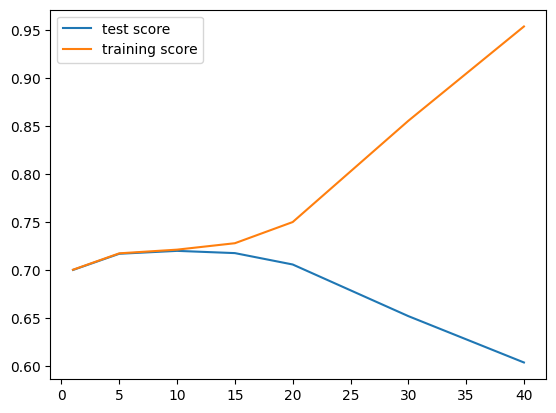

In [57]:
plt.plot(max_depths, test_scores, label = "test score")
plt.plot(max_depths, train_scores, label = "training score")
plt.legend()
plt.show()

## PCA

In [58]:
# Standardize the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [59]:
# Perform PCA to get projected values
pca = PCA().fit(X_train)
projected_X_train = pca.transform(X_train)

In [60]:
# Show explained variance
pca.explained_variance_ratio_

array([7.14383039e-01, 1.68278144e-01, 7.10615846e-02, 2.73131029e-02,
       8.16441865e-03, 4.05432567e-03, 1.77808451e-03, 7.82305700e-04,
       6.19233791e-04, 5.15814577e-04, 4.52597749e-04, 3.89574919e-04,
       3.53907346e-04, 2.88328952e-04, 2.69766097e-04, 2.15919088e-04,
       1.56462104e-04, 1.33164202e-04, 1.27606988e-04, 9.07462921e-05,
       8.61700906e-05, 8.39546381e-05, 6.71389635e-05, 5.62562439e-05,
       5.26430401e-05, 4.67890821e-05, 3.80572251e-05, 3.76131367e-05,
       3.32584445e-05, 2.32052658e-05, 1.41426411e-05, 1.15372553e-05,
       8.99906370e-06, 7.73135120e-06, 2.34697053e-06, 1.30324743e-06,
       7.25885245e-07, 5.75422210e-27, 3.21487002e-27, 1.91003533e-27,
       1.08196957e-27, 3.95317680e-28])

Plot the explained variance and number of PCs. Check for 90%, 95%, and 99% of variance

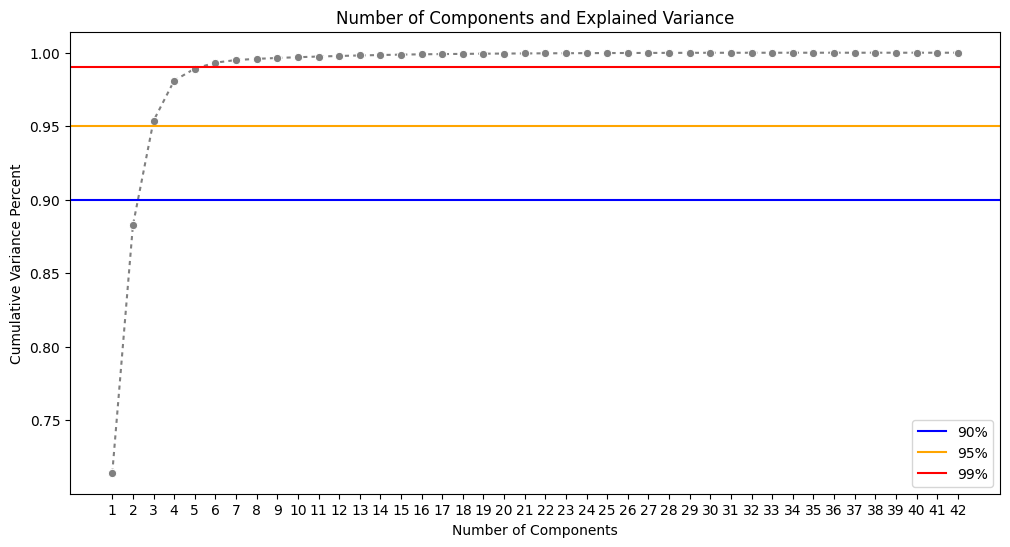

In [61]:
# get total explained variance ratio
y_axis = np.cumsum(pca.explained_variance_ratio_)
# Get number of pcs
x_axis = np.arange(1, len(y_axis) + 1, step = 1)

# Now plot it
fig = plt.figure(figsize = (12,6))
pcs = sns.lineplot(x = x_axis, y = y_axis, markers = True, color = "grey", marker = "o", dashes=[2])
# Add lines signifying cutoffs
plt.axhline(y=0.90, color='b', linestyle='-', label = "90%")
plt.axhline(y=0.95, color='orange', linestyle='-', label = "95%")
plt.axhline(y=0.99, color='r', linestyle='-', label = "99%")

pcs.set(xlabel = "Number of Components", ylabel = "Cumulative Variance Percent", 
        title = "Number of Components and Explained Variance",
        xticks = x_axis)
plt.legend()

Looks like we need 3 pcs to capture both 90% and 95% of the variance, and 6 if we want 99. Let's visualize two pcs.

In [62]:
len(X_train)

1512429

Visualize two PCs

In [63]:
# This wasn't that informative
# # Create a dataframe with the first two pcs and the classes
# two_projected = pd.DataFrame(projected_X_train[:, 0:2], columns = ["PC1", "PC2"])
# two_projected["Descriptor"] = y_train.reset_index(drop = True)["Crash Descriptor"]

# # Plot (this takes a while to run so I commented it out, also with so much data it is not very helpful)
# # sns.scatterplot(data = two_projected, x = "PC1", y = "PC2", hue = "Descriptor")

### Look at feature importance

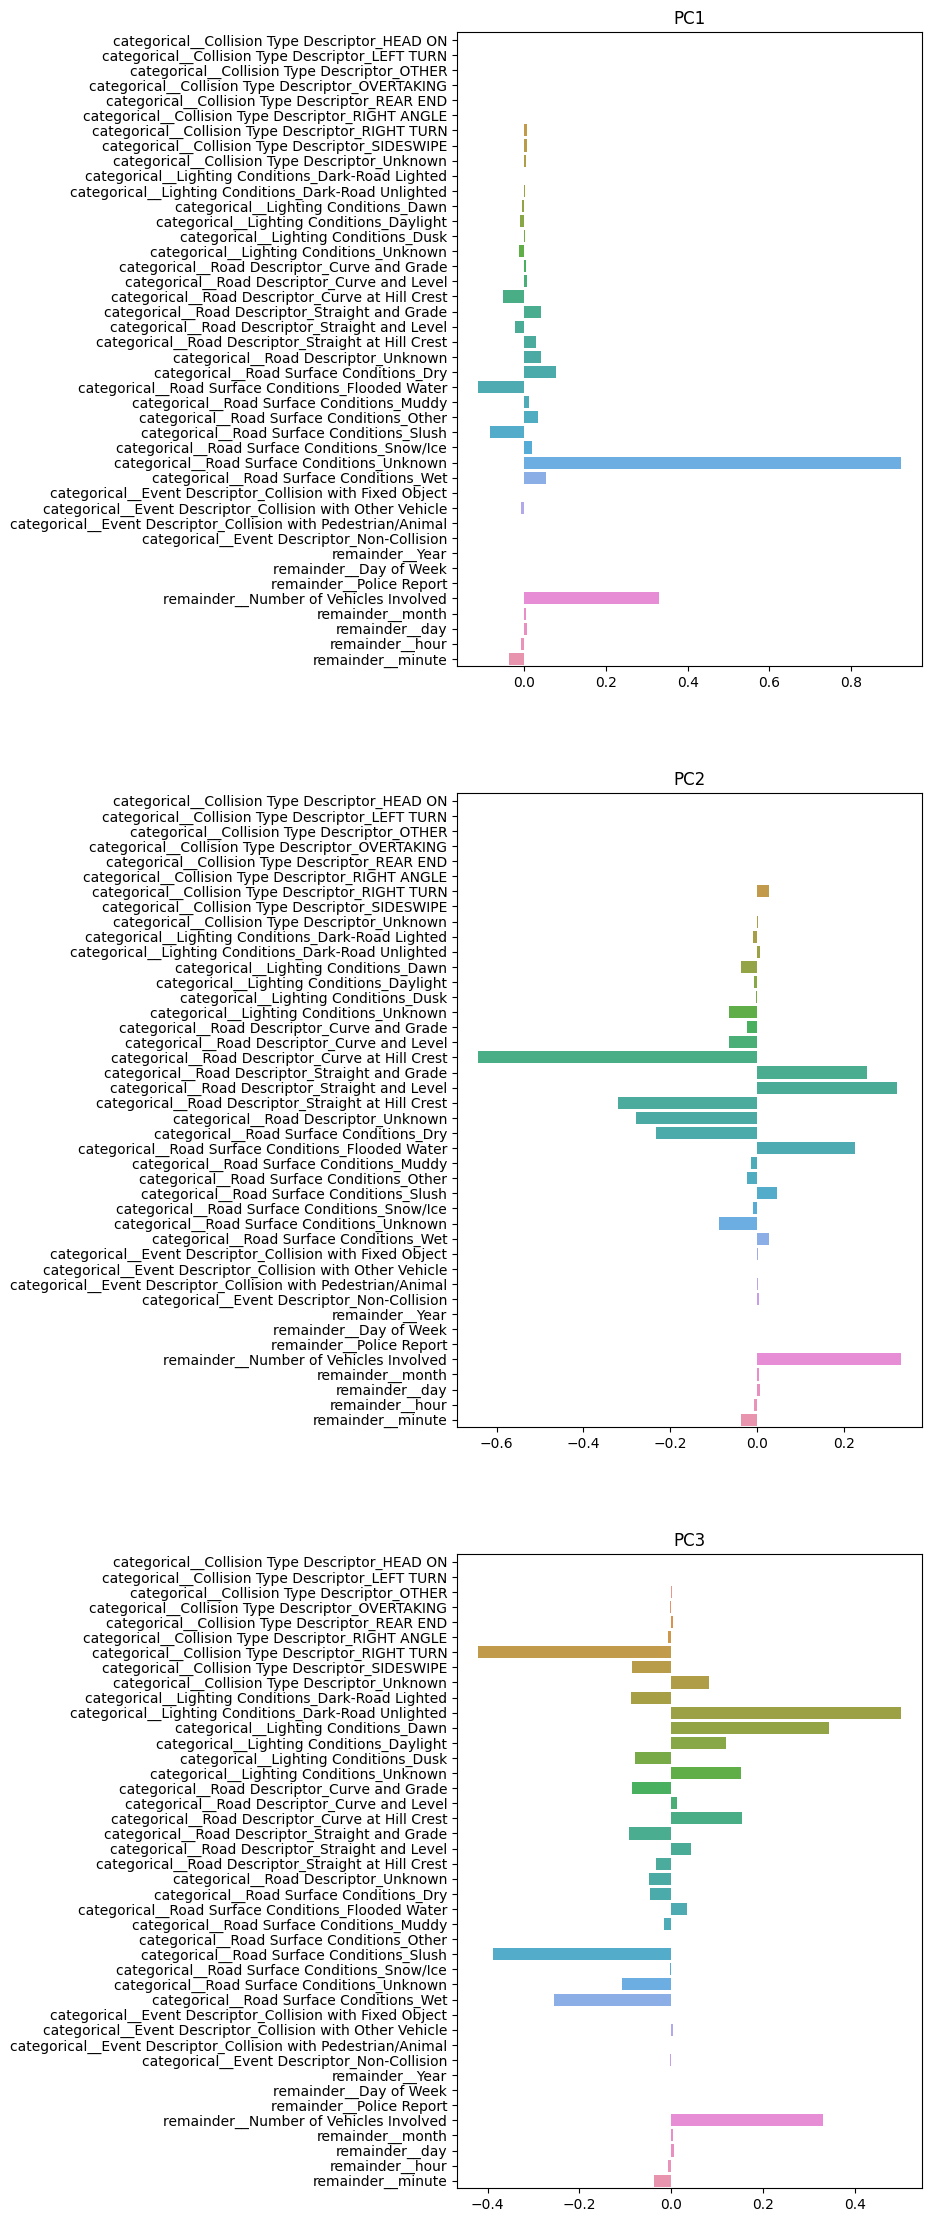

In [ ]:
# Get a list of feature names
feature_names = list(Xtransformer.get_feature_names_out())

# Let's look at the first three PCs to get 95% of the variance
fix, axs = plt.subplots(3, 1, figsize = (6, 28))

for i in range(3):
    pdat = pd.Series(pca.components_[:, i], index = feature_names)
    sns.barplot(x = pdat.values, y = pdat.index, ax = axs[i])
    axs[i].set_title(f"PC{i + 1}")

Surprisingly, it looks like whether the road surface conditions were unknown is one of the most important features. The month, and if there is a curve at the hilcrest also look fairly important.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [66]:
pca = PCA(n_components=6)

projected_X_train = pca.fit_transform(X_train)

projected_X_test = pca.transform(X_test)

projected_X_train.shape

(756214, 6)

In [67]:
model = RandomForestClassifier()

model.fit(projected_X_train, y_train)

RandomForestClassifier()

In [68]:
y_decisiontree_pred = model.predict(projected_X_test)

In [69]:
confusion_matrix(y_test, y_decisiontree_pred)

array([[     0,    104,    119,   2583],
       [    32,   9538,   5129, 105651],
       [    23,   4637,  11436, 200956],
       [    73,  14933,  35491, 743618]])

In [70]:
f1_score(y_test, y_decisiontree_pred, average='micro')

0.6740513945322453

In [71]:
model.classes_

array(['Fatal Accident', 'Injury Accident',
       'Property Damage & Injury Accident', 'Property Damage Accident'],
      dtype=object)

In [72]:
model.predict(projected_X_test[3].reshape(1,-1))

array(['Property Damage Accident'], dtype=object)